# Instructions 

1. Install tensorflow - "pip install tensorflow"   
- Install Keras - "pip install keras"
- Install scipy, numpy and scikit-learn libraries via pip. 


In [77]:
# necessary libraries 
import pickle
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import random


In [134]:
# file load helpers 
_totalBatch = 5

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadTrainigBatch(filepath):
    rawRGBFeatures = None
    trainingLabels = None
    
    for i in range(_totalBatch):
        # load all 5 batches and join the raw RGB data and indexes by row (vstack/hstack)? 
        #print(i+1)
        #print(batch1.keys())
        #print(labelMeta.keys())
        batch = unpickle(filepath + str(i + 1)) # load batch
        if i == 0: 
            rawRGBFeatures = batch.get(b"data")
            trainingLabels = batch.get(b"labels")
        else:
            rawRGBFeatures = np.vstack((rawRGBFeatures,batch.get(b"data")))
            trainingLabels = np.hstack((trainingLabels,batch.get(b"labels")))
    
    return rawRGBFeatures, trainingLabels

In [137]:
# file loads - raw data + numerical labels + text labels

rawRGBFeatures, trainingLabels = loadTrainigBatch("data/cifar-10-batches-py/data_batch_")
labelMeta = unpickle("data/cifar-10-batches-py/batches.meta") # load the label metadata
text_labels = [x.decode("utf-8") for x in labelMeta.get(b"label_names")] # to convert from byte literal to string

print(rawRGBFeatures.shape)
print(trainingLabels.shape)

# extraction unique labels 
labels = np.unique(trainingLabels)
print(labels)
print(text_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


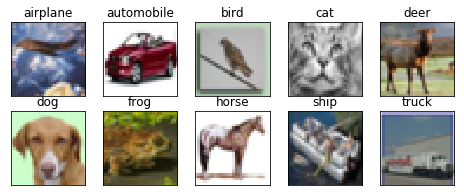

In [139]:
# view the first few images in the set and their labels 
fig = plt.figure(figsize=(8,3))
for i in labels:
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    matches = np.where(trainingLabels[:]==i)[0] # get some random indexes 
    idx = random.choice(matches) # get a random set from the overall matches for class
    rawRGB = rawRGBFeatures[idx,::] # get the raw RGB values in - stored in row-major order
    im = np.rot90(np.reshape(rawRGB, (32,32,3), order='F'), axes=(1,0)) # rotation required to fix orientation of image
    ax.set_title(text_labels[i]) # to convert from byte literal to string
    plt.imshow(im)
plt.show()